https://www.biorxiv.org/content/biorxiv/early/2018/11/04/460402.full.pdf

## SuRE-count table
SuRE-count tables were generated associating barcode sequences, genomic
positions, and counts for associated PE reads and matched SE reads for each of the biological replicates. 

For each strand separately, we determined the cDNA barcode count for all SuRE fragments overlapping
a given position. This total was divided by the total counts of the SuRE fragments measured in SuRE
library (iPCR barcode counts) to give the SuRE enrichment.

Within each transfection replicate the
genome-wide normalized SuRE enrichment was scaled to a mean of 1. Transfection replicates were
then combined by summing the SuRE enrichment scores at each position, and scaling the resulting SuRE
enrichment scores again to a genome-wide mean of 1. Then, the library replicates were also combined
and again scaled to a genome-wide mean enrichment score of 1. Of these datasets BigWig files were generated. This analysis was done disregarding variants and is therefore independent from the
identification of the raQTLs (see below). 

This will still have the sequencing depth bias.

Code adapted from Ling Chen

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import scale

In [2]:
MPRA_DIR = "/dors/capra_lab/data/mpra/arensbergen18/SuRE-count/"

In [3]:
#load all files
listofFiles = []
for root, folders, files in os.walk('/dors/capra_lab/data/mpra/arensbergen18/SuRE-count/'):
    for f in files:
        if '.txt.gz' in f:
            listofFiles += [os.path.join(root, f)]

In [4]:
def normalize_col(f, pseudocount=1):
    df = pd.read_csv(f, compression='gzip', header=0, sep='\t')
    
    #rename columns, since their libraries named differently
    for col in df.columns:
        for old, new in zip(['HEPG2_B1', 'HEPG2_B2', 'B1', 'B2', 'B3'], 
                            ['hep_1','hep_2','k562_1','k562_2','k562_3']):
            if old in col:
                df = df.rename(index=str, columns={col: new})
                col = new #rename for removing columns
                break
    dft = pd.DataFrame(columns=['k562_1', 'k562_2', 'k562_3', 'hep_1', 'hep_2'])
    dft["k562_1"] = np.log2((df["k562_1"] + pseudocount)/ (df['iPCR'] + pseudocount))
    dft["k562_2"] = np.log2((df["k562_2"] + pseudocount)/ (df['iPCR'] + pseudocount))
    dft["k562_3"] = np.log2((df["k562_3"] + pseudocount)/ (df['iPCR'] + pseudocount))
    dft["hep_1"] = np.log2((df["hep_1"] + pseudocount) / (df['iPCR'] + pseudocount))
    dft["hep_2"] = np.log2((df["hep_2"] + pseudocount) / (df['iPCR'] + pseudocount))

    return dft

### Correlation between biological replicates

In [5]:
corr_vals = []
i = 0
for f in listofFiles:
    dft = normalize_col(f)
    
    d_corr = pd.DataFrame(columns=dft.columns, index=dft.columns)
    for col1 in dft.columns:
        for col2 in dft.columns:
            if col1 == col2:
                d_corr[col1][col1] = 1
            elif pd.notnull(d_corr[col2][col1]): 
                d_corr[col1][col2] = d_corr[col2][col1]
            else:
                d_corr[col1][col2] = stats.spearmanr(dft[col1], dft[col2])[0]
    d_corr = d_corr.astype(np.float32)
    d_corr = d_corr[d_corr.columns[::-1]]
    corr_vals.append(d_corr.values)
    i += 1
    print(i)

/accre/arch/easybuild/software/BinDist/Anaconda3/4.4.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (4,6,7,8,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


1
2
3
4
5


/accre/arch/easybuild/software/BinDist/Anaconda3/4.4.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (4,5,6,7,8,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


6
7
8
9
10
11
12
13
14


/accre/arch/easybuild/software/BinDist/Anaconda3/4.4.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (4,5,6,7,8,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91


/accre/arch/easybuild/software/BinDist/Anaconda3/4.4.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (4,6,7,8,16) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184


In [6]:
vals = np.zeros((5, 5))
for i in corr_vals:
    vals += i
vals = vals / len(corr_vals)

In [7]:
vals

array([[ 0.67023297,  0.67677364,  0.65910605,  0.62969688,  1.        ],
       [ 0.64199539,  0.64628935,  0.6329141 ,  1.        ,  0.62969688],
       [ 0.67908406,  0.68667069,  1.        ,  0.6329141 ,  0.65910605],
       [ 0.76943218,  1.        ,  0.68667069,  0.64628935,  0.67677364],
       [ 1.        ,  0.76943218,  0.67908406,  0.64199539,  0.67023297]])

/accre/arch/easybuild/software/BinDist/Anaconda3/4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


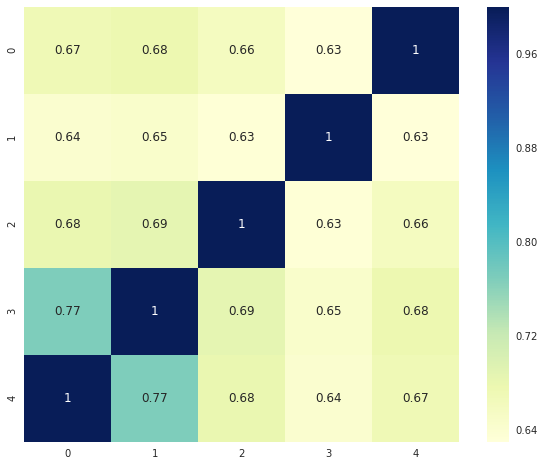

In [8]:
fig = plt.figure(figsize=(10, 8))
with sns.axes_style("white"):
    ax = sns.heatmap(vals, square=True, annot=True,
                     vmax=1, cmap="YlGnBu")

plt.show()